In [98]:
import torch.nn as nn
import torch 
import torch.optim as optim 
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [107]:
df = pd.read_csv('/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv')
df = df.rename({'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume', 'Adj Close':'adj_close'}, axis=1)
df = df.drop('adj_close', axis=1)

data = df[['date', 'close']]
data['date'] = pd.to_datetime(data['date'])

In [108]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

In [109]:
def generate_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        sequences.append(x)
        labels.append(y)
    return np.array(sequences), np.array(labels)

seq_length = 50 
x_data, y_data = generate_sequences(scaled_data, seq_length)


train_size = int(len(x_data) * 0.8)  # 80% for training
test_size = len(x_data) - train_size  # 20% for testing

x_train = x_data[:train_size]
y_train = y_data[:train_size]
x_test = x_data[train_size:]
y_test = y_data[train_size:]

In [110]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

Epoch [1/20], Loss: 0.2664
Epoch [2/20], Loss: 0.2332
Epoch [3/20], Loss: 0.2032
Epoch [4/20], Loss: 0.1765
Epoch [5/20], Loss: 0.1528
Epoch [6/20], Loss: 0.1320
Epoch [7/20], Loss: 0.1141
Epoch [8/20], Loss: 0.0992
Epoch [9/20], Loss: 0.0877
Epoch [10/20], Loss: 0.0797
Epoch [11/20], Loss: 0.0755
Epoch [12/20], Loss: 0.0747
Epoch [13/20], Loss: 0.0758
Epoch [14/20], Loss: 0.0767
Epoch [15/20], Loss: 0.0754
Epoch [16/20], Loss: 0.0714
Epoch [17/20], Loss: 0.0651
Epoch [18/20], Loss: 0.0576
Epoch [19/20], Loss: 0.0500
Epoch [20/20], Loss: 0.0432


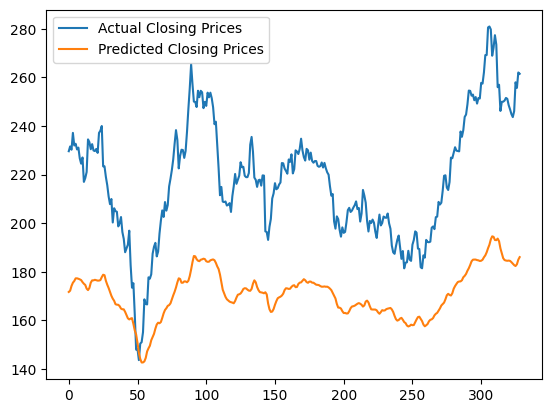

In [111]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, 50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 50)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out 
    
model = RNN()
num_epochs = 20
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
floss = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train_tensor)
    optimizer.zero_grad()
    loss = floss(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
model.eval()
with torch.no_grad():
    train_predict = model(x_test_tensor)
    train_predict = train_predict.detach().numpy()
    train_predict = scaler.inverse_transform(train_predict)
    y_data_actual = scaler.inverse_transform(y_test_tensor.detach().numpy())

    plt.plot(y_data_actual, label="Actual Closing Prices")
    plt.plot(train_predict, label="Predicted Closing Prices")
    plt.legend()
    plt.show()